In [1]:
import pandas as pd
df_wrime = pd.read_table('wrime-ver1.tsv')
df_wrime.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Sentence                   43200 non-null  object
 1   UserID                     43200 non-null  int64 
 2   Datetime                   43200 non-null  object
 3   Train/Dev/Test             43200 non-null  object
 4   Writer_Joy                 43200 non-null  int64 
 5   Writer_Sadness             43200 non-null  int64 
 6   Writer_Anticipation        43200 non-null  int64 
 7   Writer_Surprise            43200 non-null  int64 
 8   Writer_Anger               43200 non-null  int64 
 9   Writer_Fear                43200 non-null  int64 
 10  Writer_Disgust             43200 non-null  int64 
 11  Writer_Trust               43200 non-null  int64 
 12  Reader1_Joy                43200 non-null  int64 
 13  Reader1_Sadness            43200 non-null  int64 
 14  Reader

In [2]:
# Plutchikの8つの基本感情
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']

# 客観感情の平均（"Avg. Readers_*"） の値をlist化し、新しい列として定義する
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)


In [3]:
print(df_wrime.columns)
print(len(df_wrime.columns))

Index(['Sentence', 'UserID', 'Datetime', 'Train/Dev/Test', 'Writer_Joy',
       'Writer_Sadness', 'Writer_Anticipation', 'Writer_Surprise',
       'Writer_Anger', 'Writer_Fear', 'Writer_Disgust', 'Writer_Trust',
       'Reader1_Joy', 'Reader1_Sadness', 'Reader1_Anticipation',
       'Reader1_Surprise', 'Reader1_Anger', 'Reader1_Fear', 'Reader1_Disgust',
       'Reader1_Trust', 'Reader2_Joy', 'Reader2_Sadness',
       'Reader2_Anticipation', 'Reader2_Surprise', 'Reader2_Anger',
       'Reader2_Fear', 'Reader2_Disgust', 'Reader2_Trust', 'Reader3_Joy',
       'Reader3_Sadness', 'Reader3_Anticipation', 'Reader3_Surprise',
       'Reader3_Anger', 'Reader3_Fear', 'Reader3_Disgust', 'Reader3_Trust',
       'Avg. Readers_Joy', 'Avg. Readers_Sadness', 'Avg. Readers_Anticipation',
       'Avg. Readers_Surprise', 'Avg. Readers_Anger', 'Avg. Readers_Fear',
       'Avg. Readers_Disgust', 'Avg. Readers_Trust',
       'readers_emotion_intensities'],
      dtype='object')
45


In [4]:

# 感情強度が低いサンプルは除外する
# (readers_emotion_intensities の max が２以上のサンプルのみを対象とする)
is_target = df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 2)
df_wrime_target = df_wrime[is_target]


In [5]:
print(df_wrime)

                                                Sentence  UserID  \
0                         ぼけっとしてたらこんな時間｡チャリあるから食べにでたいのに…       1   
1      今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も...       1   
2                     早寝するつもりが飲み物がなくなりコンビニへ｡ん､今日、風が涼しいな。       1   
3                                               眠い、眠れない。       1   
4        ただいま? って新体操してるやん!外食する気満々で家に何もないのに!テレビから離れられない…!       1   
...                                                  ...     ...   
43195  真夜中にふと思い立ち、ノートPCを持って部屋を出て、ダイニングで仕事したらすんごい捗った。\...      80   
43196  ぐっどこんでぃしょん。\n心も頭もクリア。\n秋分の日のおかげかな？\n人と自然としっとり過...      80   
43197  朝から免許の更新へ。\n90分で終わり、出口へ向かうと献血の呼びかけが。\nみんな通り過ぎて...      80   
43198  夜も更けて参りましたが、食後のコーヒーが飲みたいのでドリップ開始…\n\nぼんやり秋の夜長を...      80   
43199  コーヒー休憩（kahavitauko）\n\nいつもの豆なのにすごく美味しくできた \n\n...      80   

               Datetime Train/Dev/Test  Writer_Joy  Writer_Sadness  \
0      2012/07/31 23:48          train           0               1   
1      2012/08/02 23:09          train     

In [6]:
# train / test に分割する
df_groups = df_wrime_target.groupby('Train/Dev/Test')
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
print('train :', len(df_train))  # train : 17104
print('test :', len(df_test))    # test : 1133


train : 17104
test : 1133


In [7]:
# HuggingFace Transformers のインストール
# - transformers : 主たるモジュール（モデルやトークナイザ)
# - datasets : HuggingFaceで、データセットを扱うためのモジュール
# cf. https://huggingface.co/docs/transformers/installation
# ! pip install transformers datasets

# 東北大学の日本語用BERT使用に必要なパッケージをインストール
# ! pip install fugashi ipadic


In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 使用するモデルを指定して、トークナイザとモデルを読み込む
checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=8)


/home/om/.miniconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializi

In [9]:
import numpy as np
from datasets import Dataset

# 1. Transformers用のデータセット形式に変換
# pandas.DataFrame -> datasets.Dataset
target_columns = ['Sentence', 'readers_emotion_intensities']
train_dataset = Dataset.from_pandas(df_train[target_columns])
test_dataset = Dataset.from_pandas(df_test[target_columns])

# 2. Tokenizerを適用（モデル入力のための前処理）
def tokenize_function(batch):
    """Tokenizerを適用 （感情強度の正規化も同時に実施する）."""
    tokenized_batch = tokenizer(batch['Sentence'], truncation=True, padding='max_length')
    tokenized_batch['labels'] = [x / np.sum(x) for x in batch['readers_emotion_intensities']]  # 総和=1に正規化
    return tokenized_batch

train_tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
test_tokenized_dataset = test_dataset.map(tokenize_function, batched=True)


In [10]:
from transformers import TrainingArguments, Trainer
from datasets import load_metric

# 評価指標を定義
# https://huggingface.co/docs/transformers/training
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    label_ids = np.argmax(labels, axis=-1)
    return metric.compute(predictions=predictions, references=label_ids)

# 訓練時の設定
# https://huggingface.co/docs/transformers/v4.21.1/en/main_classes/trainer#transformers.TrainingArguments
training_args = TrainingArguments(
    output_dir="test_trainer",
    per_device_train_batch_size=8,
    num_train_epochs=1.0,
    evaluation_strategy="steps", eval_steps=200)  # 200ステップ毎にテストデータで評価する

# Trainerを生成
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_dataset,
    eval_dataset=test_tokenized_dataset,
    compute_metrics=compute_metrics,
)

# 訓練を実行
trainer.train()


/tmp/ipykernel_7446/878362837.py:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/home/om/.miniconda3/envs/py310/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
200,No log,0.260940,0.608120
400,No log,0.244825,0.651368
600,0.298900,0.234533,0.677846
800,0.298900,0.222877,0.707855
1000,0.261600,0.220479,0.703442
1200,0.261600,0.218751,0.722860
1400,0.261600,0.212802,0.742277
1600,0.248500,0.211188,0.746690
1800,0.248500,0.208260,0.750221
2000,0.239000,0.204520,0.750221


TrainOutput(global_step=2138, training_loss=0.2605391307006493, metrics={'train_runtime': 1248.5692, 'train_samples_per_second': 13.699, 'train_steps_per_second': 1.712, 'total_flos': 4500493926531072.0, 'train_loss': 0.2605391307006493, 'epoch': 1.0})

In [11]:
import os
_dir = "trained_model"
if not os.path.isdir(_dir):
    os.makedirs(_dir)
trainer.save_model(_dir)

In [12]:
emotion_names_jp = ['喜び', '悲しみ', '期待', '驚き', '怒り', '恐れ', '嫌悪', '信頼'] 
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set(font='IPAexGothic')

import matplotlib
from matplotlib import font_manager

font_manager.fontManager.addfont("/usr/share/fonts/opentype/ipaexfont-gothic/ipaexg.ttf")
matplotlib.rc('font', family="IPAexGothic")




# ソフトマックス関数
# https://www.delftstack.com/ja/howto/numpy/numpy-softmax/
def np_softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

def analyze_emotion(text, show_fig=False):
    # 推論モードを有効化
    model.eval()

    # 入力データ変換 + 推論
    tokens = tokenizer(text, truncation=True, return_tensors="pt")
    tokens.to(model.device)
    preds = model(**tokens)
    prob = np_softmax(preds.logits.cpu().detach().numpy()[0])
    out_dict = {n: p for n, p in zip(emotion_names_jp, prob)}

    # 棒グラフを描画
    if show_fig:
        plt.figure(figsize=(8, 3))
        df = pd.DataFrame(out_dict.items(), columns=['name', 'prob'])
        sns.barplot(x='name', y='prob', data=df)
        plt.title('入力文 : ' + text, fontsize=15)
    else:
        print(out_dict)




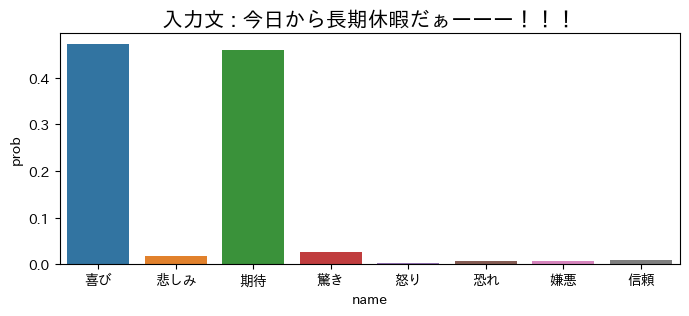

In [13]:
analyze_emotion('今日から長期休暇だぁーーー！！！', show_fig=True)

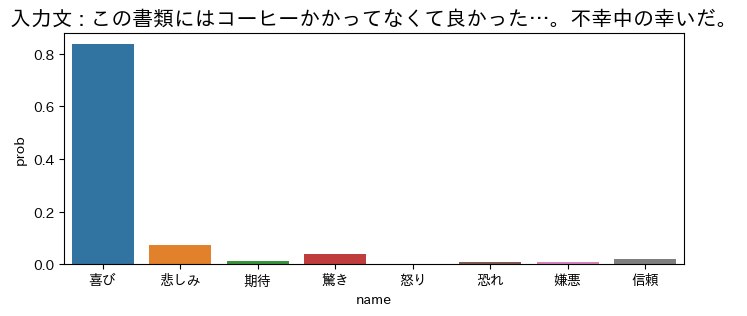

In [14]:
analyze_emotion('この書類にはコーヒーかかってなくて良かった…。不幸中の幸いだ。', show_fig=True)

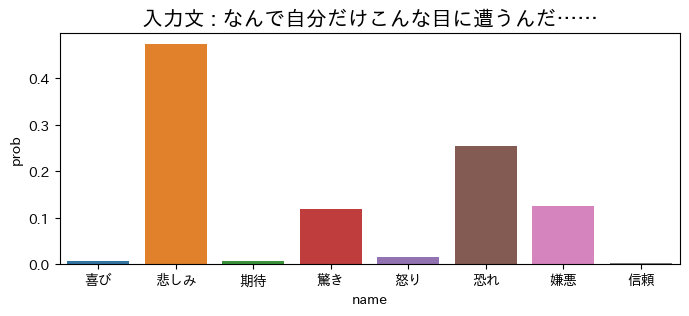

In [15]:

analyze_emotion('なんで自分だけこんな目に遭うんだ……', show_fig=True)

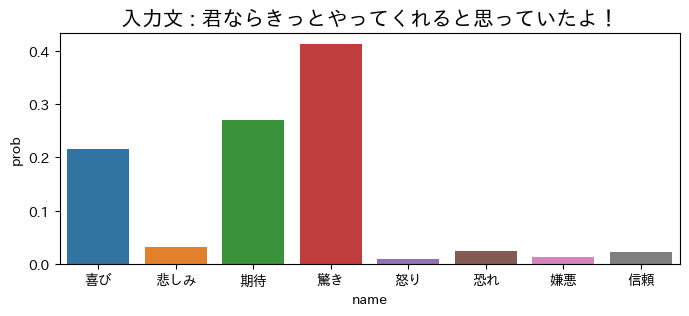

In [16]:
analyze_emotion('君ならきっとやってくれると思っていたよ！', show_fig=True)

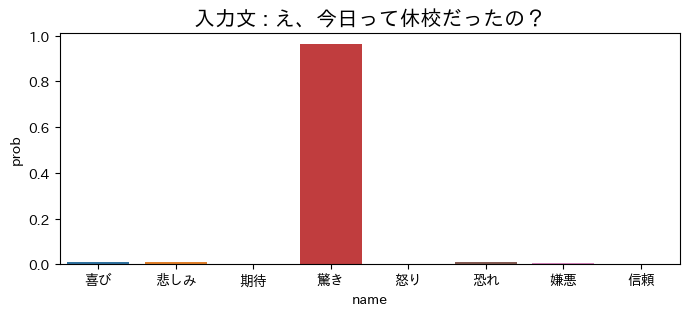

In [17]:
analyze_emotion('え、今日って休校だったの？', show_fig=True)

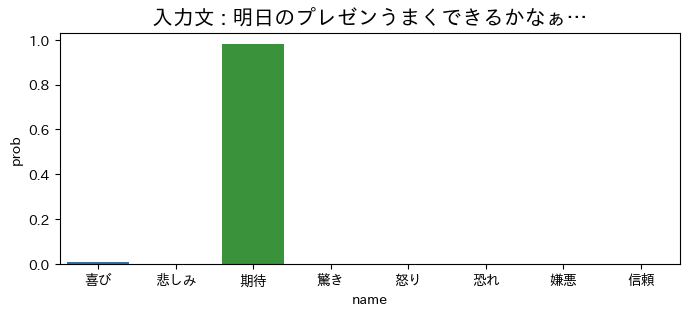

In [18]:
analyze_emotion('明日のプレゼンうまくできるかなぁ…', show_fig=True)

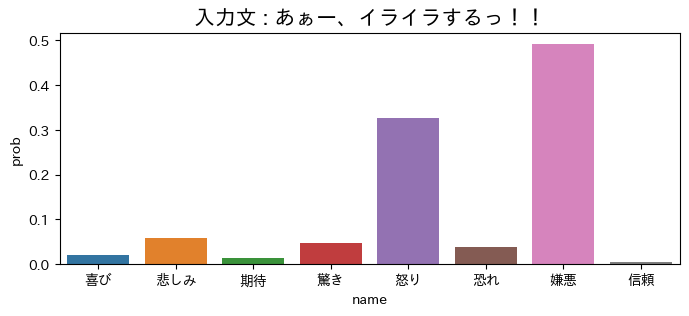

In [19]:
analyze_emotion('あぁー、イライラするっ！！', show_fig=True)